<a href="https://colab.research.google.com/github/zs856/TensorFlow-Developer-Certificate-in-2023-Zero-to-Mastery/blob/main/Introduction_to_NLP_Fundamentals_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be seqeuences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

## Check for GPU

In [1]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import  unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-02-16 01:24:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-16 01:24:14 (58.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP
dataset (text samples of Tweets labelled as diaster or not diaster).
See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-02-16 01:24:19--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 142.251.167.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2023-02-16 01:24:19 (86.1 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way 
to do so would be to use Python: 

https://realpython.com/read-write-files-python/


But I prefer to get visual straight away.


So another way to do this is to use pandas...

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df= pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe
train_df_shuffled= train_df.sample(frac=1,random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # crate random indexes not higher than the total number of samples
for row in train_df_shuffled[["text","target"]][random_index: random_index+5].itertuples():
  _,text,target = row
  print(f"Target: {target}","real diaster" if target>0 else "(not real diaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 real diaster
Text:
Philippines Must Protect Internally Displaced Persons Warns UN Expert http://t.co/xLZWTzgQTC

---

Target: 1 real diaster
Text:
'Food crematoria' provoke outrage amid crisis famine memories... http://t.co/fABVlvN5MS

---

Target: 0 (not real diaster)
Text:
#iphone #twist Ultimate #preparedness library: http://t.co/ksgmY0D0Mx Prepare Yourself For Any Catastrophe. Ov http://t.co/MZK0PFogI7

---

Target: 0 (not real diaster)
Text:
today will be another dualcom with @Im_Razed !!! if you enjoyed yesterdays check out todays at 5 pm easter!!!

---

Target: 0 (not real diaster)
Text:
Sinking carb consultative assembly plans could subconscious self live straight a leading way of escape: XkDrx

---



### split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                         train_df_shuffled["target"].to_numpy(),
                                         test_size=0.1, # use 1- % of training data for validation split,
                                         random_state=42)

In [12]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text in numbers

When dealing with a text problem, one of the first things
you'll have to do before you can build a model is to convert
your text to numbers.

There are a few ways to do this, namely:
* Tokenization -direct mapping of token (a token could be a word or a
character) to number
* Embedding - create a matrix of feature vector for each token 
(the size of the feature learned)

### Text vectorization (tokenization)

In [14]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=10000,# how many words in the vocabulary (automatically add <OOV>),
                   standardize="lower_and_strip_punctuation",
                   split="whitespace",
                   ngrams=None, # create groups of words
                   output_mode = "int", # create groups of n-words?
                   output_sequence_length = None, # how long do you want your sequences to be
                   pad_to_max_tokens=True)

In [15]:
len(train_sentences[0].split())

7

In [16]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences ) )

15

In [17]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vacabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                 output_mode="int",
                 output_sequence_length=max_length)

In [18]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [19]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
    \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 I agree with certain cultural appropriation things but honestly if u looked at my house it screams appropriation bc Buddhas and stuff-    

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   8, 1331,   14, 2530,    1, 6209,  429,   30, 1518,   47,  142,
        2404,   17,   13,  318]])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the uniqu words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {len(top_5_words)}")
print(f"5 least common words: {len(bottom_5_words)}")

Number of words in vocab: 10000
5 most common words: 5
5 least common words: 5


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's 
embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example,
 a value of 100 would mean each token gets represented 100 long
* `input_length` = length of the sequences being passed to the embedding
layer

In [22]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim= max_vocab_length,
                output_dim=128,
                embeddings_initializer="uniform",
                input_length=max_length # how long is each input
                )
embedding

In [23]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
    \n\n Embedded version:")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 @TelegraphWorld lets hope it's a upper class white mass murderer....''' Mmmm    

 Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04594226, -0.03645831,  0.00712911, ...,  0.03878795,
          0.01866242, -0.02540636],
        [ 0.04127504,  0.03462315,  0.00386765, ..., -0.03034254,
         -0.04252139,  0.01042348],
        [-0.04081737,  0.03169334,  0.02622361, ..., -0.04626269,
          0.0134769 , -0.00339732],
        ...,
        [ 0.01276363,  0.0051802 , -0.01602538, ...,  0.04153191,
          0.04407841, -0.01260151],
        [ 0.01276363,  0.0051802 , -0.01602538, ...,  0.04153191,
          0.04407841, -0.01260151],
        [ 0.01276363,  0.0051802 , -0.01602538, ...,  0.04153191,
          0.04407841, -0.01260151]]], dtype=float32)>

In [24]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.04594226, -0.03645831,  0.00712911,  0.03604725, -0.00957351,
        -0.01333549,  0.0251222 , -0.04205329,  0.03000725, -0.00511502,
        -0.03477848,  0.03320439,  0.04993335,  0.0499458 , -0.03767116,
        -0.01120217,  0.00660501, -0.02673926,  0.02736117,  0.03254887,
         0.04340154,  0.01176526,  0.04938463, -0.0039129 , -0.02031884,
         0.04534436, -0.00034185, -0.02371023, -0.01944155, -0.01247442,
         0.03935912,  0.02998959,  0.04397566, -0.02277901, -0.02434142,
        -0.01506662, -0.04637642,  0.03825745,  0.02587328,  0.02068407,
        -0.0470474 , -0.02589692, -0.00026321,  0.04838226, -0.03506712,
         0.04107591,  0.03032816,  0.03644115, -0.00020991,  0.04795175,
        -0.02860086, -0.0270991 ,  0.01432564, -0.03515195, -0.00203944,
         0.04254932,  0.02740603, -0.03046254, -0.03087023, -0.01321245,
        -0.03392911,  0.01133953,  0.02022294, -0.02035348, -0.02474139,
  

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers,
it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from Sklearn ML map:
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidrectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer
learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to apporach all of these?
Use the standard steps in modelling with tensorflow:

* Create a model
* Build amodel
* Fit a model
* Evaluate a model

### Model 0: Getting a baseline
As with all machine learning modelling experiments, it;s important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Mulinomial Naive Bayes using
the TF-IDF formula to convert our words to numbers.

> Note: It's common practice to us non-DL algorithms as a baseline
because of their speed and then later using DL to see if you can
imporve upon them

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences,val_labels)
print(f"Our baseline model achievs an accuracy of: {baseline_score * 100:.2f}%")

Our baseline model achievs an accuracy of: 79.27%


In [27]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]


array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [29]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics,
however, this will be cumbersome and could easily be fixed with a function.

Let's create one to compare our model's predictions with the truth labels using
using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

In [30]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classfication model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _= precision_recall_fscore_support(y_true,y_pred,average="weighted")
  model_results = {"accuracy": model_accuracy,
            "precision": model_precision,
            "recall": model_recall,
            "f1": model_f1}
  return model_results

In [31]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [32]:
# Create a tensorboard callback （need to create a new one for each model）
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [33]:
# Build model with the functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x) # create an embedding of the numberized inputs
# x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want  binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name = "model_1_dense")

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [35]:
# Compile model
model_1.compile(loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics = ["accuracy"])

In [36]:
# Fit the model
model_1_history= model_1.fit(x=train_sentences,
               y=train_labels,
               epochs=5,
               validation_data=(val_sentences,val_labels),
               callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230216-012422
Epoch 1/5
215/215 [==============================] - 8s 27ms/step - loss: 0.6325 - accuracy: 0.6555 - val_loss: 0.5691 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4666 - accuracy: 0.8294 - val_loss: 0.4747 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3397 - accuracy: 0.8784 - val_loss: 0.4539 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 4s 21ms/step - loss: 0.2554 - accuracy: 0.9080 - val_loss: 0.4567 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1954 - accuracy: 0.9340 - val_loss: 0.4734 - val_accuracy: 0.7822


In [37]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4734 - accuracy: 0.7822


[0.4734395444393158, 0.7821522355079651]

In [38]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [39]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [40]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                   y_pred=model_1_preds)
model_1_results

{'accuracy': 78.21522309711287,
 'precision': 0.7877268665884849,
 'recall': 0.7821522309711286,
 'f1': 0.7787825179570674}

In [41]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [42]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Visualizing learned embeddings

In [43]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [44]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [49]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for ~5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights

array([[-0.1085796 , -0.02575858, -0.07700494, ..., -0.04790403,
        -0.0674326 , -0.03111559],
       [-0.10121714, -0.0275671 , -0.06368901, ..., -0.04602059,
        -0.06767766, -0.02010179],
       [-0.06509251, -0.01679299, -0.04609485, ..., -0.06703962,
        -0.05738913, -0.03291306],
       ...,
       [ 0.02758039,  0.03019187,  0.01152258, ..., -0.03050214,
        -0.04018402, -0.01727664],
       [-0.01642279,  0.04919182, -0.04315494, ..., -0.00287989,
        -0.01065424,  0.02801652],
       [-0.02481541,  0.08538371, -0.0287295 , ..., -0.02054878,
        -0.01961271, -0.04865291]], dtype=float32)

Now we've got the embedding matrix our model has learned to represent
our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: http://projector.tensorflow.org/

And Tensorflow also has an incredible guide on word embeddings themselves:
https://www.tensorflow.org/text/guide/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk

In [50]:
# Create embedding files (we git this from TensorFlow's word embedings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [51]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Recureent Neural Networks

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text)-> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [52]:
# Creat an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.LSTM(64, return_sequences = True)(x)
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
x = layers.Dense(64, activation= "relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [53]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [54]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"])

In [55]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                train_labels,
                epochs=5,
                validation_data=(val_sentences, val_labels),
                callbacks=[create_tensorboard_callback(SAVE_DIR,"model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230216-012918
Epoch 1/5
215/215 [==============================] - 7s 24ms/step - loss: 0.3807 - accuracy: 0.8361 - val_loss: 0.4563 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2432 - accuracy: 0.9072 - val_loss: 0.5288 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.1718 - accuracy: 0.9369 - val_loss: 0.6147 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1279 - accuracy: 0.9546 - val_loss: 0.6197 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0939 - accuracy: 0.9631 - val_loss: 0.9841 - val_accuracy: 0.7717


In [56]:
# Make predictions with LSTM model
model_2__pred_probs = model_2.predict(val_sentences)
model_2__pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.00230703],
       [0.8242072 ],
       [0.999795  ],
       [0.0313331 ],
       [0.00205021],
       [0.9999706 ],
       [0.8277461 ],
       [0.99999225],
       [0.9999857 ],
       [0.48686412]], dtype=float32)

In [57]:
# Convert modl 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2__pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [58]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                   y_pred=model_2_preds)
model_2_results

{'accuracy': 77.16535433070865,
 'precision': 0.7791293682827463,
 'recall': 0.7716535433070866,
 'f1': 0.7672567495577469}

In [59]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent
unit.

The GRU cell has similar features to an LSTM cell but has less
parameters.

In [60]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs =layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name = "model_3_GRU")

In [61]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [62]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"])

In [63]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                train_labels,
                epochs=5,
                validation_data=(val_sentences,val_labels),
                callbacks=[create_tensorboard_callback(SAVE_DIR,
                                    "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230216-012944
Epoch 1/5
215/215 [==============================] - 8s 23ms/step - loss: 0.1937 - accuracy: 0.9215 - val_loss: 0.6875 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0974 - accuracy: 0.9669 - val_loss: 0.7174 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0789 - accuracy: 0.9699 - val_loss: 0.8991 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0665 - accuracy: 0.9749 - val_loss: 0.9937 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0540 - accuracy: 0.9765 - val_loss: 1.2446 - val_accuracy: 0.7717


In [64]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[1.8781138e-04],
       [6.1039847e-01],
       [9.9976438e-01],
       [6.2781565e-02],
       [1.3649241e-04],
       [9.9989235e-01],
       [9.9188608e-01],
       [9.9990022e-01],
       [9.9990582e-01],
       [8.9162093e-01]], dtype=float32)

In [65]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [66]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                   y_pred=model_3_preds)
model_3_results

{'accuracy': 77.16535433070865,
 'precision': 0.773049502603257,
 'recall': 0.7716535433070866,
 'f1': 0.7697096359746837}

### Model 4: Bidrectional RNN

Normal RNN's go from left to right (just like you'd sread an English 
sentence) however, a bidirectional RNN goes from right to left as well
as left to right.

In [67]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [68]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                             

In [69]:
# Compile model
model_4.compile(loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"])

In [70]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                train_labels,
                epochs=5,
                validation_data=(val_sentences, val_labels),
                callbacks=[create_tensorboard_callback(SAVE_DIR,"model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230216-013029
Epoch 1/5
215/215 [==============================] - 18s 51ms/step - loss: 0.1217 - accuracy: 0.9568 - val_loss: 0.9271 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 9s 42ms/step - loss: 0.0634 - accuracy: 0.9739 - val_loss: 1.0279 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 9s 40ms/step - loss: 0.0525 - accuracy: 0.9761 - val_loss: 1.1487 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 9s 42ms/step - loss: 0.0429 - accuracy: 0.9787 - val_loss: 1.8068 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 9s 42ms/step - loss: 0.0457 - accuracy: 0.9790 - val_loss: 1.3605 - val_accuracy: 0.7612


In [71]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[7.3367362e-03],
       [5.7459903e-01],
       [9.9976665e-01],
       [2.3529260e-01],
       [2.5292291e-05],
       [9.9995816e-01],
       [9.4061053e-01],
       [9.9997479e-01],
       [9.9996173e-01],
       [8.3121777e-01]], dtype=float32)

In [72]:
# Convert pred probs o pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [73]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                   y_pred=model_4_preds)
model_4_results

{'accuracy': 76.11548556430446,
 'precision': 0.7612627209133627,
 'recall': 0.7611548556430446,
 'f1': 0.7598431815524319}

In [74]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### 1D Convolutional Neural Network

We've used CNNs for images but images ares typically 2D (height * width)
...however, oyt text data is 1D.

Previously we've Conv2D for our image data but now we're going to use
Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):
```
Inputs (text) -> Tokenization -> Embedding -> Layer(s)
(typically Conv1D + pooling) -> Outpus (class probabilities)

### Model 5: Conv1D

For different explanations of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate
1D data)

* Difference between "same" and "valid" padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [75]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=64,
             kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
             strides=1, # default
             activation="relu",
             padding="same") # default = "valid", the output is smaller than the input shape, "same" means output is same shape as input
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest" 
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 64]), TensorShape([1, 64]))

In [76]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.09113242, -0.00958658, -0.04850151, ..., -0.06693354,
         -0.08442527, -0.00571118],
        [-0.06605668, -0.06414277, -0.00457383, ..., -0.03989825,
         -0.05272823, -0.04686037],
        [-0.04737524, -0.04738245,  0.00038254, ..., -0.02440342,
         -0.03700876, -0.04553024],
        ...,
        [-0.08723652, -0.02082578, -0.04596107, ..., -0.03031716,
         -0.03637241, -0.01991101],
        [-0.08723652, -0.02082578, -0.04596107, ..., -0.03031716,
         -0.03637241, -0.01991101],
        [-0.08723652, -0.02082578, -0.04596107, ..., -0.03031716,
         -0.03637241, -0.01991101]]], dtype=float32)>

In [77]:
conv_1d_output

<tf.Tensor: shape=(1, 15, 64), dtype=float32, numpy=
array([[[3.88522558e-02, 0.00000000e+00, 1.99179165e-02, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 1.33598633e-02, 1.10550709e-02,
         1.46168377e-02, 0.00000000e+00, 0.00000000e+00, 2.03368627e-02,
         0.00000000e+00, 1.15314126e-02, 4.73724641e-02, 2.01886520e-02,
         1.84193999e-02, 0.00000000e+00, 4.24611755e-02, 0.00000000e+00,
         3.68745923e-02, 0.00000000e+00, 4.55405563e-03, 0.00000000e+00,
         7.10368156e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         4.30875346e-02, 2.74965838e-02, 1.01946294e-02, 3.72011699e-02,
         1.59083493e-02, 2.43560709e-02, 0.00000000e+00, 0.00000000e+00,
         5.29264361e-02, 0.00000000e+00, 4.89838347e-02, 0.00000000e+00,
         2.02714633e-02, 4.41401638e-02, 0.00000000e+00, 4.88928482e-02,
         1.55948605e-02, 2.36879364e-02, 2.74646524e-02, 2.07678750e-02,
         1.16437171e-02, 4.31033596e-02, 4.36570719e-02, 0.00000000e+00

In [78]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5,strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D
model_5.compile(loss="binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"])
model_5.summary() 

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)              

In [79]:
# Fit th model
model_5_history = model_5.fit(train_sentences,
                train_labels,
                epochs=5,
                validation_data=(val_sentences, val_labels),
                callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230216-013124
Epoch 1/5
215/215 [==============================] - 4s 13ms/step - loss: 0.1468 - accuracy: 0.9578 - val_loss: 0.8832 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0765 - accuracy: 0.9727 - val_loss: 1.0059 - val_accuracy: 0.7546
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0609 - accuracy: 0.9762 - val_loss: 1.0419 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0556 - accuracy: 0.9774 - val_loss: 1.0735 - val_accuracy: 0.7467
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0553 - accuracy: 0.9793 - val_loss: 1.1277 - val_accuracy: 0.7520


In [80]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[4.5372425e-03],
       [9.4498879e-01],
       [9.9994200e-01],
       [8.6416982e-02],
       [6.4954097e-06],
       [9.9731004e-01],
       [7.4456590e-01],
       [9.9990296e-01],
       [9.9999732e-01],
       [2.8548005e-01]], dtype=float32)

In [81]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [82]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true= val_labels,
                   y_pred=model_5_preds)
model_5_results

{'accuracy': 75.19685039370079,
 'precision': 0.753207335992147,
 'recall': 0.7519685039370079,
 'f1': 0.7496488116181164}

In [83]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer
learning for NLP, specifically using TensorFlow Hub's Universal
Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

In [84]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
            "When you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [85]:
embed_samples[0].shape

TensorShape([512])

In [86]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encode_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape=[],
                                       dtype=tf.string,
                                       trainable=False,
                                       name="USE"
                     )

In [87]:
# Create model using the Sequential API
model_6 =tf.keras.Sequential([
    sentence_encode_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid",name="output_layer")
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"])
model_6.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [88]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                train_labels,
                epochs=5,
                validation_data=(val_sentences, val_labels),
                callbacks=[create_tensorboard_callback(SAVE_DIR,"tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230216-013204
Epoch 1/5
215/215 [==============================] - 5s 15ms/step - loss: 0.5020 - accuracy: 0.7843 - val_loss: 0.4503 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4140 - accuracy: 0.8159 - val_loss: 0.4391 - val_accuracy: 0.8045
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4006 - accuracy: 0.8206 - val_loss: 0.4323 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3925 - accuracy: 0.8246 - val_loss: 0.4295 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3855 - accuracy: 0.8305 - val_loss: 0.4288 - val_accuracy: 0.8123


In [89]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 0s 8ms/step


array([[0.22316754],
       [0.7642753 ],
       [0.9902375 ],
       [0.22730199],
       [0.7905447 ],
       [0.7758979 ],
       [0.98187906],
       [0.97926235],
       [0.95916355],
       [0.099905  ]], dtype=float32)

In [90]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [91]:
# Calculate model 6 perfomance metrics
model_6_results = calculate_results(y_true = val_labels,
                  y_pred=model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8135161424410383,
 'recall': 0.8123359580052494,
 'f1': 0.8111730155404432}

In [92]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate
model_6 except we'll train it on 10% of the data.

In [93]:
# ## NOTE: Makinbg data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
# ## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET
# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text","target"]].sample(frac=0.1, random_state=42)
# train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

> **Note** Be *very* careful when creating training/val/
test splits that you don't leak data across the datasets, otherwise
your model evaluation metrics will be wrong.  If something looks too good
to be true ( a model trained on 10% of data outperforming the same mdoel trained
on 100% of data)
trust your gut and go back through to find where the error may lie.

In [94]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[: train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_labels_10_percent)

685

In [95]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

To recreate a model the same as a previous model you've created you
can uyse the `tf.keras.models.clone_model()` method, see more here https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [98]:
# Let's build a model the same as model_6
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"])
# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [99]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent, 
                train_labels_10_percent,
                epochs=5,
                validation_data=(val_sentences,val_labels),
                callbacks=[create_tensorboard_callback(SAVE_DIR,"tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20230216-013254
Epoch 1/5
22/22 [==============================] - 3s 36ms/step - loss: 0.6658 - accuracy: 0.7066 - val_loss: 0.6419 - val_accuracy: 0.7375
Epoch 2/5
22/22 [==============================] - 0s 23ms/step - loss: 0.5914 - accuracy: 0.8131 - val_loss: 0.5783 - val_accuracy: 0.7677
Epoch 3/5
22/22 [==============================] - 1s 23ms/step - loss: 0.5142 - accuracy: 0.8088 - val_loss: 0.5253 - val_accuracy: 0.7664
Epoch 4/5
22/22 [==============================] - 0s 23ms/step - loss: 0.4556 - accuracy: 0.8175 - val_loss: 0.4962 - val_accuracy: 0.7638
Epoch 5/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4164 - accuracy: 0.8350 - val_loss: 0.4833 - val_accuracy: 0.7782


In [100]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 0s 7ms/step


array([[0.19831352],
       [0.62198055],
       [0.9401872 ],
       [0.34448436],
       [0.55145496],
       [0.73335284],
       [0.9075215 ],
       [0.8348709 ],
       [0.86431724],
       [0.16901174]], dtype=float32)

In [101]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [102]:
# Evaluate model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                   y_pred=model_7_preds)
model_7_results

{'accuracy': 77.82152230971128,
 'precision': 0.7782520175632252,
 'recall': 0.7782152230971129,
 'f1': 0.7772416104347588}

In [103]:
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8135161424410383,
 'recall': 0.8123359580052494,
 'f1': 0.8111730155404432}

## Comparing the performance of each of ou models

In [104]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                  "1_simple_dense": model_1_results,
                  "2_lstm": model_2_results,
                  "3_gru": model_3_results,
                  "4_bidirectional": model_4_results,
                  "5_conv1d": model_5_results,
                  "6_tf_hub_use_encoder": model_6_results,
                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()

In [105]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.782152,0.787727,0.782152,0.778783
2_lstm,0.771654,0.779129,0.771654,0.767257
3_gru,0.771654,0.773050,0.771654,0.769710
4_bidirectional,0.761155,0.761263,0.761155,0.759843
5_conv1d,0.751969,0.753207,0.751969,0.749649
6_tf_hub_use_encoder,0.812336,0.813516,0.812336,0.811173
7_tf_hub_use_encoder_10_percent,0.778215,0.778252,0.778215,0.777242


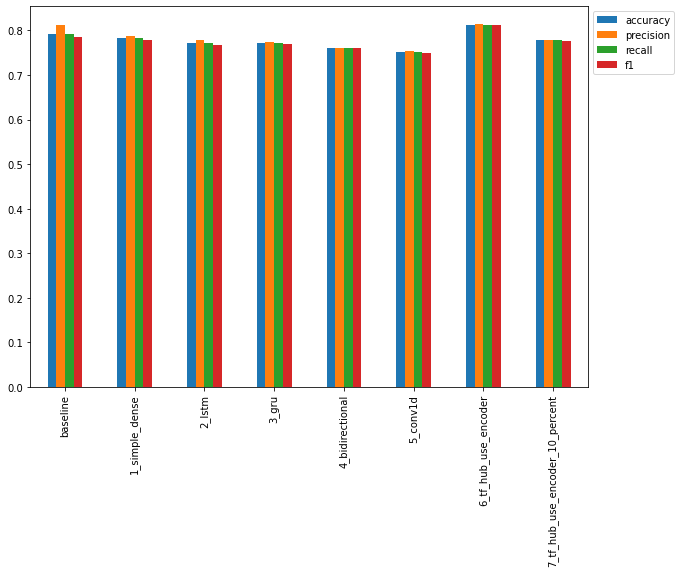

In [106]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

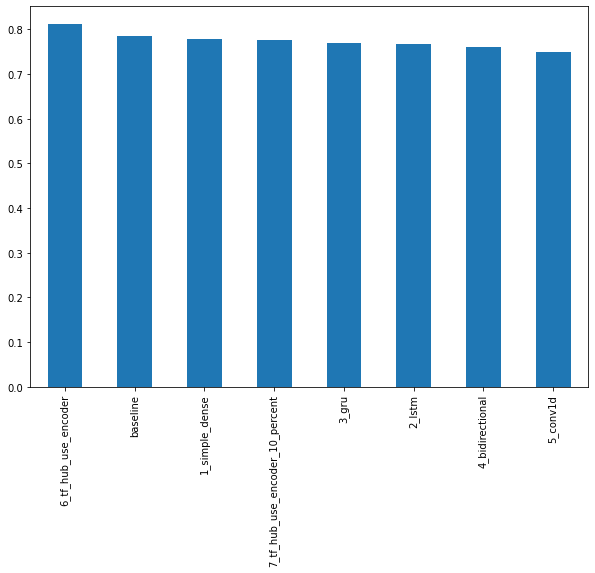

In [107]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

## uploading our model training logs to TensorBoard.dev
https://tensorboard.dev/

In [ ]:
# View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP modelling Experiments ZEM TF Course Video" \
  --description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset" \
  --one_shot # exit the uploader once uploading is finished

Now I've ran the cell above, my modelling experiments are visable on TensorBoard.dev
> **Resource:** TensorBoard is great for quickly tracking experiments
but for quickly tracking experiments but for larger sacle experiments
and a whole bunch more tracking options, check out Weights & Biases:
https://wandb.ai/site

In [ ]:
# See the previous TensorBoard Dev experiments you've run ...
!tensorboard dev list

In [ ]:
# If you need to delete an experiment from TensorBoard, you can run the following:
!tensorboard dev delete --experiment_id {experiment_id}

## Saving and loading a trainer model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SaveModel` format (this is the default when using Tensorflow)

In [112]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [113]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5", custom_objects={"KerasLayer":hub.KerasLayer})

In [114]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 15ms/step - loss: 0.4288 - accuracy: 0.8123


[0.4288128614425659, 0.8123359680175781]

Now let's save to the `SaveModel` format... (see more on this here: https://www.tensorflow.org/tutorials/keras/save_and_load?hl=zh-cn)

In [116]:
# Save TF Hub Sentence Encoer model to SavedModel format (default)
model_6.save("model_6_SaveModel_format")

In [118]:
# Load in a d model from the SaveModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SaveModel_format")

In [121]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4288 - accuracy: 0.8123


[0.4288128614425659, 0.8123359680175781]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of thee wrong examples which ones is it getting *most* wrong (thos will prediction probabilities closest to the opposite class)

For exampl if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice vera.



In [122]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-02-16 02:15:10--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.62.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   180MB/s    in 4.9s    

2023-02-16 02:15:15 (186 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.in

In [123]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 8ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [125]:
#Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_pred = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_pred[:10]

24/24 [==============================] - 0s 8ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [131]:
# Create DataFrame with validation sentences, validation labels and best performing model predictions labels + probabilities
val_df = pd.DataFrame({"text": val_sentences,
             "target": val_labels,
             "pred": model_6_pretrained_pred,
             "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [136]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values(("pred_prob"), ascending=False)
most_wrong[:10] # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835455
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


Let's remind ourselves of the target labels

* `0` = not disaster
* `1` = disaster

In [137]:
most_wrong.tail() # these are false negative

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [139]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _,text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354545831680298
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.8148159384727478
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

---

In [140]:
# Check the false negative (model predicted 0 when should've been 1)
for row in most_wrong[:-10].itertuples():
  _,text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354545831680298
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.8148159384727478
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

---

## Making predictions on the test dataset

In [145]:
# Making predictions on the test datast and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob:{pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

1/1 [==============================] - 0s 448ms/step
Pred: 1, Prob:0.5024018883705139
Text:
MicrosoftÛªs Nokia acquisition was an even bigger disaster than we ever imagined https://t.co/4MneTInGXl

-----

1/1 [==============================] - 0s 31ms/step
Pred: 1, Prob:0.9758628010749817
Text:
#Children traumatised after the Nepal earthquake are educated on coping mechanisms.   http://t.co/UbwDBydK1a

-----

1/1 [==============================] - 0s 31ms/step
Pred: 1, Prob:0.6174471974372864
Text:
.@denisleary Not sure how these folks rush into burning buildings but I'm grateful they do. #TrueHeroes

-----

1/1 [==============================] - 0s 40ms/step
Pred: 0, Prob:0.43346625566482544
Text:
ThorCon: A Thorium Molten Salt Reactor System that can be built Now https://t.co/K90M1qoE9q #thorium #Auspol #climate #nuclearrcSA #nuclear

-----

1/1 [==============================] - 0s 37ms/step
Pred: 0, Prob:0.2843116521835327
Text:
@AlyssaSpencer28 remember when beau and i collided o

## Your challenge... predicting on Tweets from the wild
Go to your favouurite Twitter account and copy one of their latest Tweets.

Then pass that Tweet through our trained model.
Is that Tweet disaster or not a disaster (according to the model)? Is the model right or wrong

In [147]:
event = """Rescuers saved a dog from the rubble in Turkey yesterday. It was so afraid to come out at first.

So much grief and so many miracles happening after these horrible earthquakes."""
pred_prob = tf.squeeze(model_6_pretrained.predict([event])) # our model expects a list as input
pred = tf.round(pred_prob)
print(f"Pred: {int(pred)}, Prob:{pred_prob}")
print(f"Text:\n{event}\n")
print("-----\n")

1/1 [==============================] - 0s 34ms/step
Pred: 1, Prob:0.9639112949371338
Text:
Rescuers saved a dog from the rubble in Turkey yesterday. It was so afraid to come out at first.

So much grief and so many miracles happening after these horrible earthquakes.

-----



## The speed/score tradeoff

In [148]:
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8135161424410383,
 'recall': 0.8123359580052494,
 'f1': 0.8111730155404432}

In [149]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [156]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples)
  end_time = time.perf_counter() # get finish time
  total_time =end_time-start_time # calculate how long predictions took to mak
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [157]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 7ms/step


(0.2424294299999019, 0.00031814885826758784)

In [158]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.06323084799987555, 8.298011548540098e-05)

In [161]:
# Gt results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true = val_labels,
                        y_pred=model_6_pretrained_pred)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

Text(0, 0.5, 'F1-score')

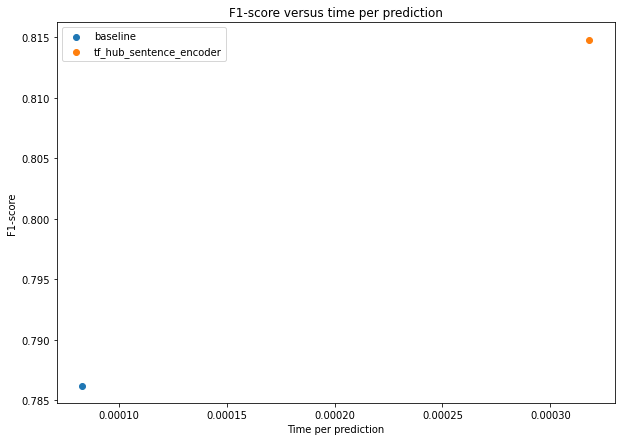

In [165]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label = "baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")